In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
npts = 10000
sigma = 0.2

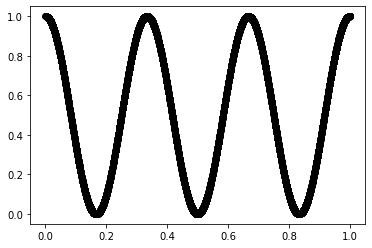

In [3]:
#generate the data
def gen_data(npts):
    
    x = np.zeros((npts,2))
    y = np.zeros((npts,2))

    for ii in range(npts):

        a = np.random.rand()
        x[ii,0] = a
        y[ii,0] = np.square(np.cos(3*np.pi*a))
    return x,y
    
train_x,train_y = gen_data(npts)
test_x,test_y = gen_data(npts)

plt.scatter(train_x[:,0],train_y[:,0],c = 'k')
#plt.axis('equal')
plt.show()



In [4]:
def initiate_layers(architecture):
    n_layers = len(architecture)
    params = {}
    
    for idx, layer in enumerate(architecture):
        
        input_size = layer['input_dim']
        output_size = layer['output_dim']
        func = layer['function']
        
        params['W' + str(idx)] = np.random.randn(output_size,input_size)
        params['b' + str(idx)] = np.random.randn(output_size)
        params['f' + str(idx)] = func
    
    return params

In [5]:
def costx(truth,guess):
    return 0.5*np.sum(np.square(truth - guess))

In [6]:
def sigmoid(vector):
    return 1/(1 + np.exp(-vector))

In [7]:
def dsig(vec):
    return sigmoid(vec)*(1 - sigmoid(vec))

In [8]:
def update_weights(architecture,params,gradients,learning_rate):
    for idx, layer in enumerate(architecture):
        params['W' + str(idx)] += -gradients['dCdw' + str(idx)]*learning_rate
        params['b' + str(idx)] += -gradients['dCdb' + str(idx)]*learning_rate
    return params

In [9]:
def forward_prop_one(architecture,params,inpt):
    memory = {}
    A = inpt[:]
    
    for idx, layer in enumerate(architecture):
        A_prec = A
        
        W = params['W' + str(idx)]
        b = params['b' + str(idx)]
        func = params['f' + str(idx)]
        
        z = np.add(np.dot(W,A_prec),b)
        #print('dot shape = ',np.shape(np.dot(W,A_prec)))
        #print('b shape = ', np.shape(b))
        #print('z shape = ',np.shape(z))
        if func == 'sigmoid':
            A = sigmoid(z)
        else:
            A = z
        #print('A shape = ',np.shape(A))
        
        memory['A_in' + str(idx)] = A_prec
        memory['z' + str(idx)] = z
    
    return A, memory

In [10]:
def plot_status(architecture,params,test_r,test_ident,npts,bigtitle):
    guesses = np.zeros(np.shape(test_ident))
    for ii in range(npts):
        guess,mem = forward_prop_one(architecture,params,test_r[ii,:])
        #print(guess)
        guesses[ii,:] = guess
    
    fig, (ax1,ax2) = plt.subplots(1,2)
    fig.suptitle(bigtitle)
    ax1.scatter(test_x[:,0],test_y[:,0],c = 'k')
    ax1.set_title('truth')
    #ax1.axis('equal')
    #ax1.axis('off')
    
    ax2.scatter(test_x[:,0],guesses[:,0],c = 'r')
    ax2.set_title('estimate')
    #ax2.axis('equal')
    #ax2.axis('off')
    plt.show()
    
    print('distance = ',np.sum(np.square(guesses[:,0] - test_y[:,0]))/np.size(guesses[:,0]))
    
    return np.sum(np.square(guesses[:,0] - test_y[:,0]))/np.size(guesses[:,0])

In [11]:
def back_prop_one(memory,params,truth,guess,architecture):
    #this will calculate the gradients for one training example
    
    delta = {}
    gradients = {}
    nlayer = len(architecture)
    
    for idx, layer in enumerate(architecture):
        
        
        l = nlayer - (idx + 1)
        zl = memory['z' + str(l)]
        Alm1 = memory['A_in' + str(l)]
        
        #print(l)
        
        if l == (nlayer - 1):
            dl = (guess - truth)*dsig(zl)
        else:
            Wl1 = params['W' + str(l + 1)]
            dl1 = delta['d' + str(l + 1)]
            dl = np.dot(np.transpose(Wl1),dl1)*dsig(zl)
        
        delta['d' + str(l)] = dl
        gradients['dCdb' + str(l)] = dl
        gradients['dCdw' + str(l)] = np.outer(dl,Alm1)
    
    return delta, gradients

In [12]:
def average_gradients(grads,architecture,start,stop):
    
    av_grads = {}
    cutoff = stop-start
    
    for idx, layer in enumerate(architecture):
        dCdw = 0
        dCdb = 0
        for ii in range(start,stop):
            dCdw += grads['G' + str(ii)]['dCdw' + str(idx)]
            dCdb += grads['G' + str(ii)]['dCdb' + str(idx)]
        av_grads['dCdw' + str(idx)] = dCdw/cutoff
        av_grads['dCdb' + str(idx)] = dCdb/cutoff
    
    return av_grads

In [13]:
in_dim = 2
nneuron = 24
out_dim = 2
nbatches = 1000

nepoch = 1000
learning_rate = 0.1

In [14]:
ARCHITECTURE = [
    {'input_dim': in_dim, 'output_dim': nneuron, 'function': 'sigmoid'},
    {'input_dim': nneuron, 'output_dim': nneuron, 'function': 'sigmoid'},
    {'input_dim': nneuron, 'output_dim': out_dim, 'function': 'sigmoid'},
]

In [15]:
#lets try to train a model
def train_weights(ARCHITECTURE,nbatches,nepoch,learning_rate,train_r,train_ident,test_r,test_ident):
    cutoff = int(npts/nbatches)

    params = initiate_layers(ARCHITECTURE)
        
    errs = []
    epchs = []
    #e1 = plot_status(ARCHITECTURE,params,test_r,test_ident,npts,'pre-training')

    for tt in range(nepoch):
        for batch in range(nbatches):
            grad_storage = {}
            start = int(batch*cutoff)
            stop = int((batch + 1)*cutoff)
            for ii in range(start,stop):
                inpt = train_x[ii]
                truth = train_y[ii]
                guess,memory = forward_prop_one(ARCHITECTURE,params,inpt)
                delta,gradients = back_prop_one(memory,params,truth,guess,ARCHITECTURE)

                grad_storage['G' + str(ii)] = gradients

        #actually average gradients over epochs
            av_grads = average_gradients(grad_storage,ARCHITECTURE,start,stop)
            params = update_weights(ARCHITECTURE,params,gradients,learning_rate)
        if tt%100 == 0:
            error = plot_status(ARCHITECTURE,params,test_r,test_ident,npts,'epoch %s' %tt)
            errs.append(error)
            epchs.append(tt)
    error = plot_status(ARCHITECTURE,params,test_r,test_ident,npts,'post-training')
    errs.append(error)
    epchs.append(tt)
    
    errs = np.asarray(errs)
    epchs.append(epchs)
    
    return params, errs, epchs

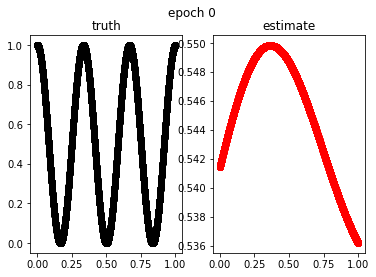

distance =  0.12668483609803458


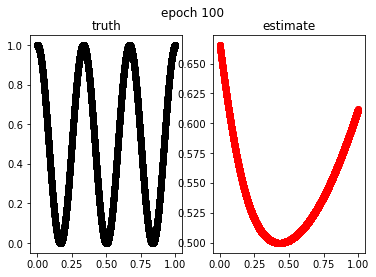

distance =  0.12442948882487233


In [ ]:
params,err,epchs = train_weights(ARCHITECTURE,nbatches,nepoch,learning_rate,train_x,train_y,test_x,test_y)

In [ ]:
plt.plot(epchs,err)